In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#### Data & Libraries

In [ ]:
'''
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
'''

#### done

### 5.1 나이브 베이즈

In [3]:
# 데이터 불러오기
LOAN_DATA_CSV = ''
loan_data = pd.read_csv(LOAN_DATA_CSV)

In [15]:
# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

In [4]:
# 범주형 피처 -> 더미 변수로 변환 
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

In [5]:
# 하나의 예측변수의 요인 수준만큼의 칼럼이 새로 생김 
X.columns

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business', 'MORTGAGE',
       'OWN', 'RENT', ' < 1 Year', ' > 1 Year'],
      dtype='object')

In [10]:
len(X.columns)

12

In [6]:
from sklearn.naive_bayes import MultinomialNB

In [7]:
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model.fit(X, y)

MultinomialNB(alpha=0.01)

In [9]:
# 각 클래스별 특징의 로그 확률 출력
print(naive_model.feature_log_prob_)

[[-2.98568079 -1.65075848 -3.91515406 -4.38810745 -5.34359996 -3.25614089
  -4.18335906 -1.93946238 -3.58417726 -1.82144088 -4.15016524 -1.14705315]
 [-2.77207366 -1.69253222 -3.73665122 -4.02494832 -5.34977262 -3.40212145
  -4.96201704 -1.81302493 -3.6131958  -1.94345848 -4.57066335 -1.13015885]]


In [11]:
naive_model.feature_log_prob_.shape # y값 차원: 2, 더미 변수 개수: 12

(2, 12)

In [13]:
# 새로운 데이터에 대한 예측 
new_loan = X.loc[146:146, :]
## 예측한 클래스 반환
print('predicted class: ', naive_model.predict(new_loan)[0])

predicted class:  default


In [17]:
## 클래스별 확률 반환
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan), columns=loan_data[outcome].cat.categories)
print('predicted probabilities', probabilities)

predicted probabilities     default  paid off
0  0.653696  0.346304


### 5.2 LDA

In [2]:
loan_3000_path = ''
loan3000 = pd.read_csv(loan_3000_path)

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
loan3000.outcome = loan3000.outcome.astype('category')

In [5]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

In [6]:
X = loan3000[predictors]
y = loan3000[outcome]

In [7]:
loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

LinearDiscriminantAnalysis()

In [8]:
# discriminator weight
pd.DataFrame(loan_lda.scalings_, index=X.columns)

,0
borrower_score,7.175839
payment_inc_ratio,-0.099676


In [9]:
# class probabilites
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]), columns=loan_lda.classes_)

In [10]:
pred.head()

,default,paid off
0,0.553544,0.446456
1,0.558953,0.441047
2,0.272696,0.727304
3,0.506254,0.493746
4,0.609952,0.390048


In [11]:
loan_lda.means_ # 각 클래스에 속하는 데이터 포인트들의 각 예측 변수의 평균값을 계산

array([[0.46280277, 8.86181347],
       [0.53906752, 7.4651989 ]])

In [12]:
loan_lda.means_.shape

(2, 2)

In [15]:
# visualization
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

In [16]:
x_0 = (0 - intercept) / slope # 0 = slope * x + intercept 
x_20 = (20 - intercept) / slope

In [17]:
lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio,default
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135,0.553544
1,16982,default,credit_card,15.49,0.40,5.43165,0.558953
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003,0.272696
3,34580,paid off,major_purchase,21.11,0.40,2.33482,0.506254
4,14424,default,debt_consolidation,16.46,0.45,12.10320,0.609952


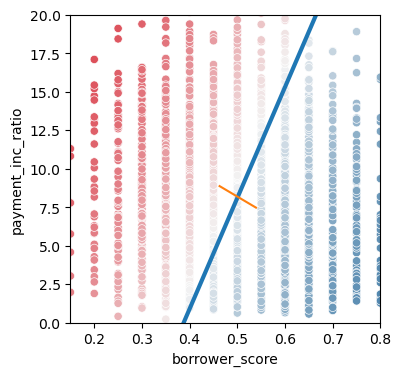

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio', hue='default', data=lda_df,
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True), ax=ax, legend=False)
# 축 스케일링
ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)

# 추가 직선 얹기 
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

###### check last graph

In [25]:
[*loan_lda.means_.transpose()]

[array([0.46280277, 0.53906752]), array([8.86181347, 7.4651989 ])]

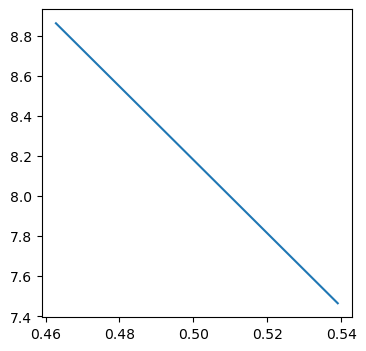

In [28]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(*loan_lda.means_.transpose())

###### done

### 5.3 로지스틱 회귀

In [12]:
# 데이터 불러오기
LOAN_DATA_CSV = ''
loan_data = pd.read_csv(LOAN_DATA_CSV)

# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

In [13]:
# 범주형 피처 -> 더미 변수로 변환 
predictors = ['purpose_', 'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y) # 계수 부호가 R이랑 반대로 나옴-클래스 요인(0,1)이 R이랑 반대라서 

LogisticRegression(C=1e+42, solver='liblinear')

In [16]:
pd.DataFrame(logit_reg.predict_log_proba(X), columns=loan_data[outcome].cat.categories)

,default,paid off
0,-1.204133,-0.356606
1,-0.959035,-0.483312
2,-0.809458,-0.588966
3,-0.649149,-0.739171
4,-0.685617,-0.700735
...,...,...
45337,-0.464009,-0.990900
45338,-0.675295,-0.711323
45339,-0.889431,-0.529141
45340,-1.192948,-0.361437


In [17]:
# logistic model로부터 얻은 예측값(로그 확률) -> 분포 특성 
pred = pd.DataFrame(logit_reg.predict_log_proba(X), columns=loan_data[outcome].cat.categories)
pred.describe()

,default,paid off
count,45342.000000,45342.000000
mean,-0.744143,-0.745512
std,0.332622,0.339960
min,-2.433844,-2.952425
25%,-0.922355,-0.964934
50%,-0.685617,-0.700735
75%,-0.479663,-0.506803
max,-0.053625,-0.091785


In [18]:
# 로그 오즈가 아닌 확률값을 얻는 method는 predict_proba
pred = pd.DataFrame(logit_reg.predict_proba(X), columns=loan_data[outcome].cat.categories)
pred.describe()

,default,paid off
count,45342.000000,45342.000000
mean,0.500000,0.500000
std,0.150466,0.150466
min,0.087699,0.052213
25%,0.397582,0.381008
50%,0.503779,0.496221
75%,0.618992,0.602418
max,0.947787,0.912301


In [19]:
# 모델 평가
import statsmodels.api as sm
y_numbers = [1 if yi == 'default' else 0 for yi in y] 
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45331
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29291.
Date:                Fri, 26 Jul 2024   Deviance:                       58583.
Time:                        17:02:58   Pearson chi2:                 4.53e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.08996
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
borrower_score        -4.7050      0.083    -56.463      0.000      -4.868      -4.542
credit_card          1.46e+10   1.73e+11      0.084      0.933   -3.25e+11    3.54e+11
debt_consolidation   1.46e+10   1.73e+11      0.084      0.933   -3.25e+11    3.54e+11
home_improvement     1.46e+10   1.73e+11      0.084      0.933   -3.25e+11    3.54e+11
major_purchase       1.46e+10   1.73e+11      0.084      0.933   -3.25e+11    3.54e+11
medical              1.46e+10   1.73e+11      0.084      0.933   -3.25e+11    3.54e+11
other                1.46e+10   1.73e+11      0.084      0.933   -3.25e+11    3.54e+11
small_business       1.46e+10   1.73e+11      0.084      0.933   -3.25e+11    3.54e+11
MORTGAGE            4.353e+10   2.05e+11      0.212      0.832   -3.58e+11    4.45e+11
OWN                 4.353e+10   2.05e+11      0.212      0.832   -3.58e+11    4.45e+11
RENT                4.353e+10   2.05e+11      0.212      0.832   -3.58e+11    4.45e+11
 < 1 Year          -3.249e+11   4.89e+11     -0.664      0.507   -1.28e+12    6.34e+11
 > 1 Year          -3.249e+11   4.89e+11     -0.664      0.507   -1.28e+12    6.34e+11
const               2.668e+11   5.58e+11      0.478      0.633   -8.27e+11    1.36e+12
======================================================================================
"""

In [20]:
# 로지스틱 모델 확장
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=4) + purpose_ +' + 'home_ + emp_len_ + bs(borrower_score, df=4)')

In [22]:
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()

In [24]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45324
Model Family:                                       Binomial   Df Model:                           17
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28744.
Date:                                       Fri, 26 Jul 2024   Deviance:                       57487.
Time:                                               17:06:06   Pearson chi2:                 4.54e+04
No. Iterations:                                            5   Pseudo R-squ. (CS):             0.1117
Covariance Type:                                   nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.8382      0.380      4.836      0.000       1.093       2.583
purpose_[T.debt_consolidation]     0.2491      0.028      9.020      0.000       0.195       0.303
purpose_[T.home_improvement]       0.4138      0.047      8.848      0.000       0.322       0.505
purpose_[T.major_purchase]         0.2401      0.054      4.450      0.000       0.134       0.346
purpose_[T.medical]                0.5183      0.087      5.953      0.000       0.348       0.689
purpose_[T.other]                  0.6295      0.040     15.812      0.000       0.552       0.708
purpose_[T.small_business]         1.2252      0.063     19.303      0.000       1.101       1.350
home_[T.OWN]                       0.0484      0.038      1.273      0.203      -0.026       0.123
home_[T.RENT]                      0.1581      0.021      7.456      0.000       0.117       0.200
emp_len_[T. > 1 Year]             -0.3541      0.053     -6.729      0.000      -0.457      -0.251
bs(payment_inc_ratio, df=4)[0]     0.0049      0.121      0.041      0.967      -0.232       0.241
bs(payment_inc_ratio, df=4)[1]     1.6033      0.142     11.289      0.000       1.325       1.882
bs(payment_inc_ratio, df=4)[2]     1.9033      0.488      3.900      0.000       0.947       2.860
bs(payment_inc_ratio, df=4)[3]    -0.8521      1.929     -0.442      0.659      -4.633       2.929
bs(borrower_score, df=4)[0]       -1.0045      0.476     -2.112      0.035      -1.937      -0.072
bs(borrower_score, df=4)[1]       -2.6411      0.287     -9.209      0.000      -3.203      -2.079
bs(borrower_score, df=4)[2]       -3.6984      0.473     -7.824      0.000      -4.625      -2.772
bs(borrower_score, df=4)[3]       -5.8564      0.525    -11.160      0.000      -6.885      -4.828
==================================================================================================
"""

In [25]:
# 편잔차 그림 그리기
from statsmodels.genmod.generalized_linear_model import GLMResults

def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    
    # set model parametes of other features to 0
    # 특정 피처가 종속 변수에 미치는 기여도를 분리하여 부분 잔차를 계산
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
        
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)

    # 예측된 확률 값을 로짓 값으로 변환
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial) # 왜 R이랑 구하는 방법이 다른지 모르겠음 
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

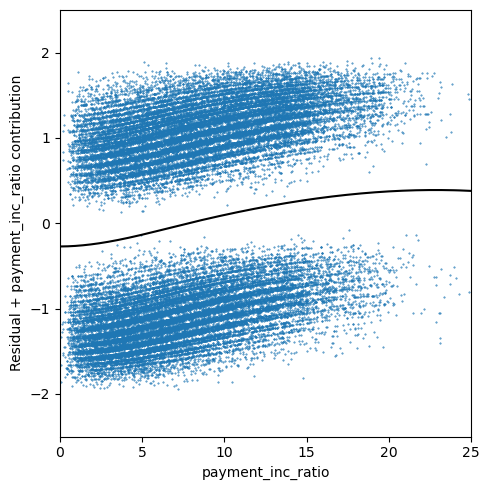

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

### 5.4 분류 모델 평가

In [2]:
# 데이터 불러오기
LOAN_DATA_CSV = ''
loan_data = pd.read_csv(LOAN_DATA_CSV)

# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])

loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

# 범주형 피처 -> 더미 변수로 변환 
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True, dtype=int)
y = loan_data[outcome]

In [24]:
np.unique(y)

array(['default', 'paid off'], dtype=object)

In [3]:
from sklearn.linear_model import LogisticRegression

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

LogisticRegression(C=1e+42, solver='liblinear')

In [4]:
# confusion matrix 만들기 
pred =logit_reg.predict(X)
pred_y = logit_reg.predict(X) =='default'
true_y = y == 'default'

In [5]:
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y

false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

In [14]:
conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)],
                         [np.sum(false_pos), np.sum(true_neg)]],
                        index = ['Y = default', 'Y = paid off'],
                        columns=['Yhat = default', 'Yhat = paid_off'])
conf_mat

,Yhat = default,Yhat = paid_off
Y = default,14336,8335
Y = paid off,8148,14523


In [15]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
conf_mat = confusion_matrix(y, logit_reg.predict(X))

In [16]:
conf_mat

array([[14336,  8335],
       [ 8148, 14523]])

In [17]:
precision = conf_mat[0, 0] / sum(conf_mat[:, 0])
precision

0.6376089663760897

In [18]:
recall = conf_mat[0, 0] / sum(conf_mat[0, :])
recall

0.6323496978518812

In [19]:
specificity = conf_mat[1, 1]/ sum(conf_mat[1, :])
specificity

0.6405981209474659

In [20]:
precision_recall_fscore_support(y, logit_reg.predict(X), labels=['default', 'paid_off'])

/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.63760897, 0.        ]),
 array([0.6323497, 0.       ]),
 array([0.63496844, 0.        ]),
 array([22671,     0]))

In [23]:
np.unique(pred)

array(['default', 'paid off'], dtype=object)

In [25]:
precision_recall_fscore_support(y, logit_reg.predict(X), labels=['default', 'paid off'])

(array([0.63760897, 0.63535742]),
 array([0.6323497 , 0.64059812]),
 array([0.63496844, 0.63796701]),
 array([22671, 22671]))

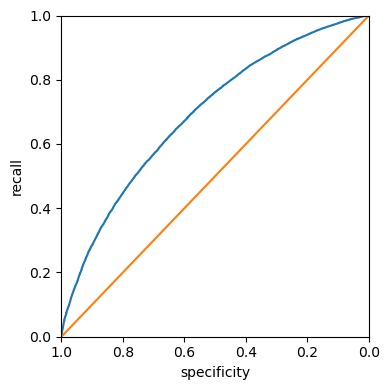

In [26]:
# ROC curve - sklearn!!
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()

In [27]:
# AUC 면적 구하기 - 적분 계산
np.sum(roc_df.recall[:-1] * np.diff(1-roc_df.specificity))

0.6917107913974234

In [34]:
np.sum(roc_df.recall[1:] * np.diff(1-roc_df.specificity))

0.6917109470472471

In [29]:
# AUC 면적 구하기 - sklearn 모듈 이용
roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0])

0.6917108692223353

In [33]:
logit_reg.predict_proba(X)

array([[0.24250184, 0.75749816],
       [0.3144073 , 0.6855927 ],
       [0.51662729, 0.48337271],
       ...,
       [0.44768059, 0.55231941],
       [0.2783303 , 0.7216697 ],
       [0.54263247, 0.45736753]])

### 5.5 불균형 데이터 다루기
- github에서 제공하는 결과랑 수치 차이가 좀 있다. 데이터랑 코드가 같은데 아무래도 라이브러리 버전 차이인듯

In [2]:
# 원래 데이터 - default, paid_off 균형
LOAN_DATA_CSV = ''
loan_data = pd.read_csv(LOAN_DATA_CSV)

In [3]:
np.mean(loan_data.outcome == 'default')

0.5

In [4]:
# full 데이터 - default가 희귀 클래스
FULL_TRAIN_SET_CSV = ''
full_train_set = pd.read_csv(FULL_TRAIN_SET_CSV)

In [5]:
np.mean(full_train_set.outcome == 'default')

0.18894546909248502

In [6]:
full_train_set.columns

Index(['status', 'loan_amnt', 'term', 'annual_inc', 'dti', 'payment_inc_ratio',
       'revol_bal', 'revol_util', 'purpose', 'home_ownership',
       'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc', 'grade', 'outcome',
       'emp_length', 'purpose_', 'home_', 'emp_len_'],
      dtype='object')

In [7]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']

In [8]:
full_train_set[predictors].dtypes

payment_inc_ratio    float64
purpose_              object
home_                 object
emp_len_              object
dti                  float64
revol_bal            float64
revol_util           float64
dtype: object

In [17]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', drop_first=True, dtype=int)
y = full_train_set[outcome]

In [18]:
from sklearn.linear_model import LogisticRegression

In [28]:
full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)

LogisticRegression(C=1e+42, solver='liblinear')

In [29]:
np.mean(full_model.predict(X) == 'default')

0.00750081258803037

In [36]:
# 가중치 이용하여 upsampling
upsampling_wt = 1/np.mean(full_train_set.outcome == 'default')
upsampling_wt

5.292532309999559

In [37]:
wt = [upsampling_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]

In [38]:
full_model.fit(X, y, sample_weight=wt)

LogisticRegression(C=1e+42, solver='liblinear')

In [39]:
np.mean(full_model.predict(X) == 'default')

0.6136664805353913

In [27]:
import sklearn
print(sklearn.__version__)

1.1.3


In [41]:
# data generation
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

In [42]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('percentage of loans in default (SMOTE resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (SMOTE): ', 
      100 * np.mean(full_model.predict(X) == 'default'))


X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('percentage of loans in default (ADASYN resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (ADASYN): ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

percentage of loans in default (SMOTE resampled):  50.0
percentage of loans predicted to default (SMOTE):  29.398184803353693
percentage of loans in default (ADASYN resampled):  48.56040383751355
27.242117896105412
percentage of loans predicted to default (ADASYN):  None


In [2]:
# 모델 간 예측 결과 분석
loan_3000_path = ''
loan3000 = pd.read_csv(loan_3000_path)

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from pygam import LinearGAM, s, f, l

In [4]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', 
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)


## model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


In [5]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

In [9]:
predict = models['Generalized Additive Model'].predict(X)

In [10]:
predict.shape

(19488,)

In [11]:
Z = np.array([1 if z > 0.5 else 0 for z in predict])
Z

array([1, 1, 1, ..., 0, 0, 0])

In [12]:
xx.shape

(203, 96)

In [13]:
203*96

19488

In [14]:
yvalues[np.argmax(Z > 0, axis=0)]

-0.1

In [27]:
predict = models['Decision Tree'].predict(X)
predict

array(['default', 'default', 'default', ..., 'paid off', 'paid off',
       'paid off'], dtype=object)

In [28]:
predict = models['Logistic Regression'].predict(X)
predict

array(['default', 'default', 'default', ..., 'paid off', 'paid off',
       'paid off'], dtype=object)

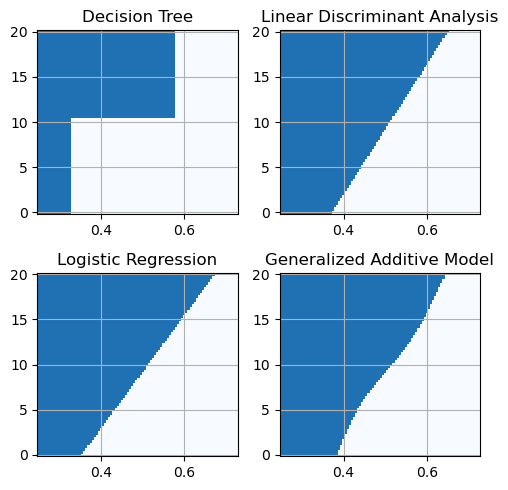

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = pd.DataFrame({
    'borrower_score': xx.ravel(),
    'payment_inc_ratio': yy.ravel(),
})

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    
    if 'Generalized' in title: # 모델이 확률을 출력하는 이진 분류 모델을 의미. gam
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:
        
        Z = np.array([1 if z == 'default' else 0 for z in predict]) # 바로 클래스로 예측
        
    Z = Z.reshape(xx.shape)

    # 각 열에서 처음으로 1이 되는 위치의 y 값을 결정 경계로 설정
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    # 마지막 행이 0인 경우, 해당 위치의 결정 경계를 y 축의 마지막 값으로 설정
    boundary[title][Z[-1,:] == 0] = yvalues[-1] # 우리 데이터에서 여기 해당되는 경우는 없음

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [19]:
boundary.keys()

dict_keys(['Decision Tree', 'Linear Discriminant Analysis', 'Logistic Regression', 'Generalized Additive Model', 'borrower_score'])

In [24]:
for v in boundary:
    print(type(boundary[v]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


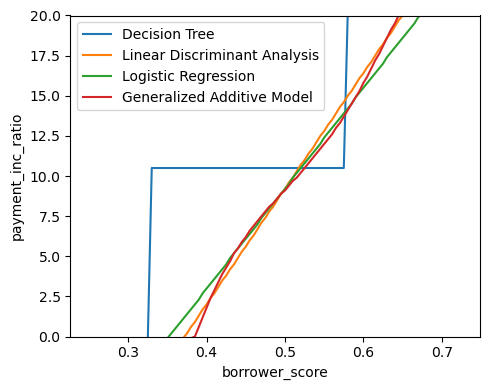

In [17]:
boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)

fig, ax = plt.subplots(figsize=(5, 4))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)


plt.tight_layout()
plt.show()